# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
sample_size = 10000
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 64
fuzzification_kernel_size = 16
enrich_lemmas_with_wn = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
# X_train, y_train, X_test, y_test = (
#     X_train[:sample_size],
#     y_train[:sample_size],
#     # X_train[:sample_size],
#     # y_train[:sample_size],
#     X_test[:sample_size],
#     y_test[:sample_size]
# )
# evaluating space on full, combined training+test set, as fuzzification model is nonparametric
X_test = pd.concat([X_train, X_test])
y_test = pd.concat([y_train, y_test])

sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel()
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_test["sent_1"].to_list() + X_test["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.24045217,  0.0774674 ,  0.04887389, ...,  0.04259023,
         0.03923956, -0.00857224],
       [ 0.08702144, -0.12343182, -0.21419266, ..., -0.05334185,
        -0.02110416, -0.03904926],
       [ 0.14292802,  0.2383385 , -0.24700809, ..., -0.0075179 ,
        -0.0846687 ,  0.06752189],
       ...,
       [-0.26377052,  0.13076055, -0.0963241 , ...,  0.00960438,
         0.10680684,  0.01275183],
       [ 0.37495556, -0.08553488, -0.17383507, ...,  0.02490567,
        -0.01862817,  0.00155901],
       [ 0.13288409, -0.15729412, -0.01607927, ...,  0.11481179,
         0.0079161 , -0.03198214]], dtype=float32)

In [5]:
X_test = model.fit(X_test)
X_test = model.predict_batch(X_test, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate model

In [6]:
eval_harness.fit(X_test)
sims_df = eval_harness.get_similarities(X_test)
sims_df.head()


	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for baseline_sent approac

,fuzzy_baseline_sent_cos_sim,fuzzy_baseline_tok_cos_sim,fuzzy_intersection+intersection_cos_sim,fuzzy_intersection+mean_cos_sim,fuzzy_intersection+union_cos_sim,fuzzy_mean_cos_sim,fuzzy_selective_intersection+intersection+mean_cos_sim,fuzzy_selective_intersection+mean_cos_sim,fuzzy_selective_intersection+union_cos_sim,fuzzy_baseline_sent_wasserstein-1_sim,...,fuzzy_baseline_tok_quantum_sim,fuzzy_intersection+intersection_quantum_sim,fuzzy_intersection+mean_quantum_sim,fuzzy_intersection+union_quantum_sim,fuzzy_mean_quantum_sim,fuzzy_selective_intersection+intersection+mean_quantum_sim,fuzzy_selective_intersection+mean_quantum_sim,fuzzy_selective_intersection+union_quantum_sim,baseline_sent_cos_sim,baseline_tok_cos_sim
0,0.092385,-0.078494,0.001865,0.004435,0.001865,-0.040224,0.004857,0.004857,0.010894,-0.070202,...,-0.059888,-0.000074,-0.000105,-0.000074,-0.132629,-0.000045,-0.000045,0.001004,-0.146005,-0.134878
1,-0.294901,0.016370,-0.000026,0.000911,-0.000026,0.052166,-0.000363,-0.000363,0.003172,-0.053570,...,0.014435,0.000010,0.000001,0.000010,0.059318,-0.000091,-0.000091,0.001588,-0.156038,0.036879
2,-0.180831,-0.262618,0.004004,0.002682,0.004004,-0.177636,0.004825,0.004825,0.000520,-0.040088,...,-0.193654,-0.000110,-0.000069,-0.000110,-0.358467,-0.000017,-0.000017,-0.025253,-0.127968,-0.292754
3,-0.048714,-0.028220,-0.000427,-0.000490,-0.000427,-0.048896,-0.016613,-0.016613,-0.050344,-0.024655,...,-0.025532,0.000014,0.000010,0.000014,-0.028607,-0.000132,-0.000132,-0.004776,-0.175541,-0.037645
4,0.299780,0.044601,0.000483,0.000126,0.000483,0.169382,-0.016385,-0.016385,-0.054722,0.150293,...,0.012601,-0.000032,-0.000034,-0.000032,0.197744,-0.000097,-0.000097,-0.003843,0.361268,0.130475


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

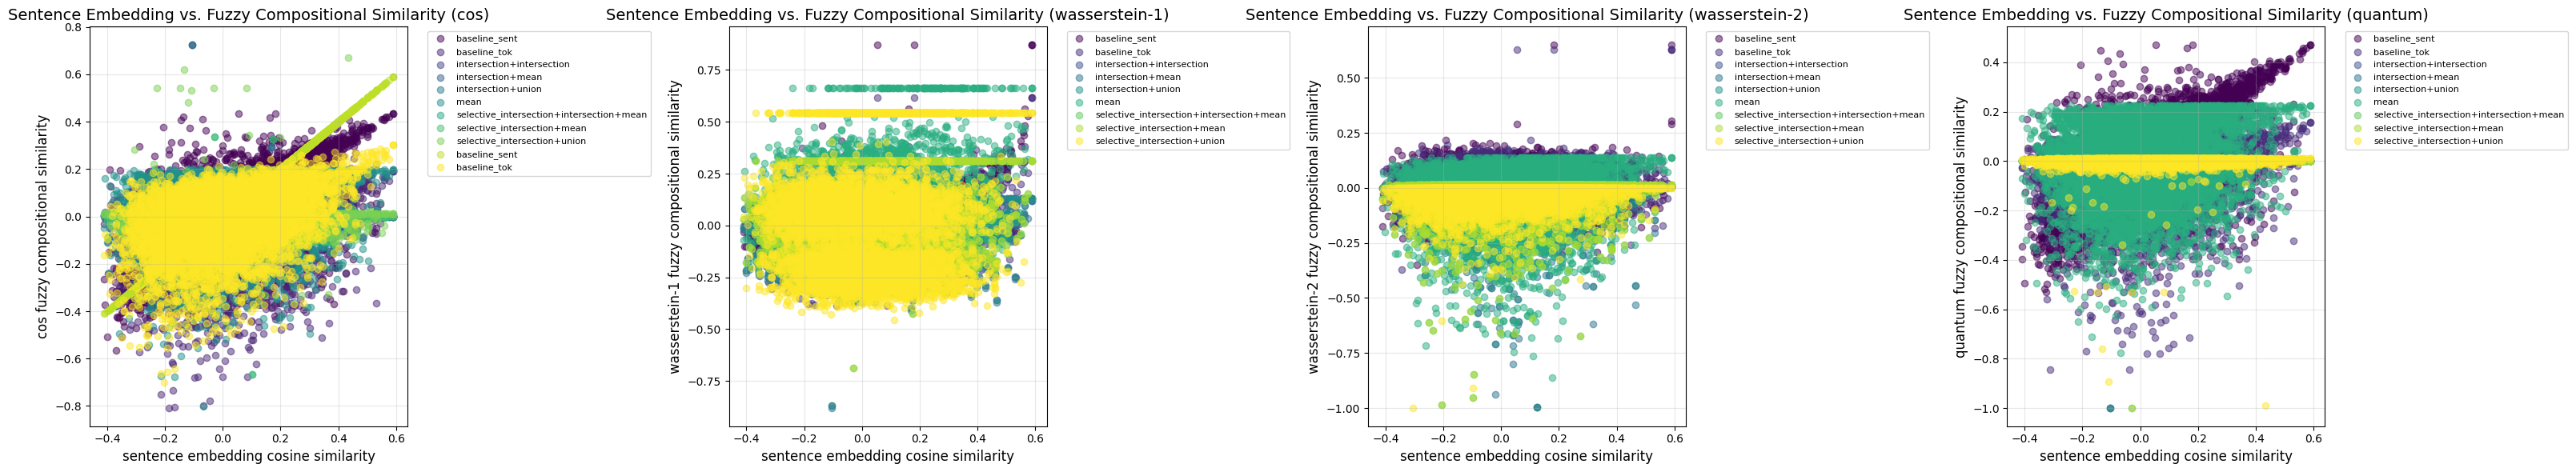

In [8]:
eval_harness.visualize_similarities(sims_df)

## Confusion Matrices

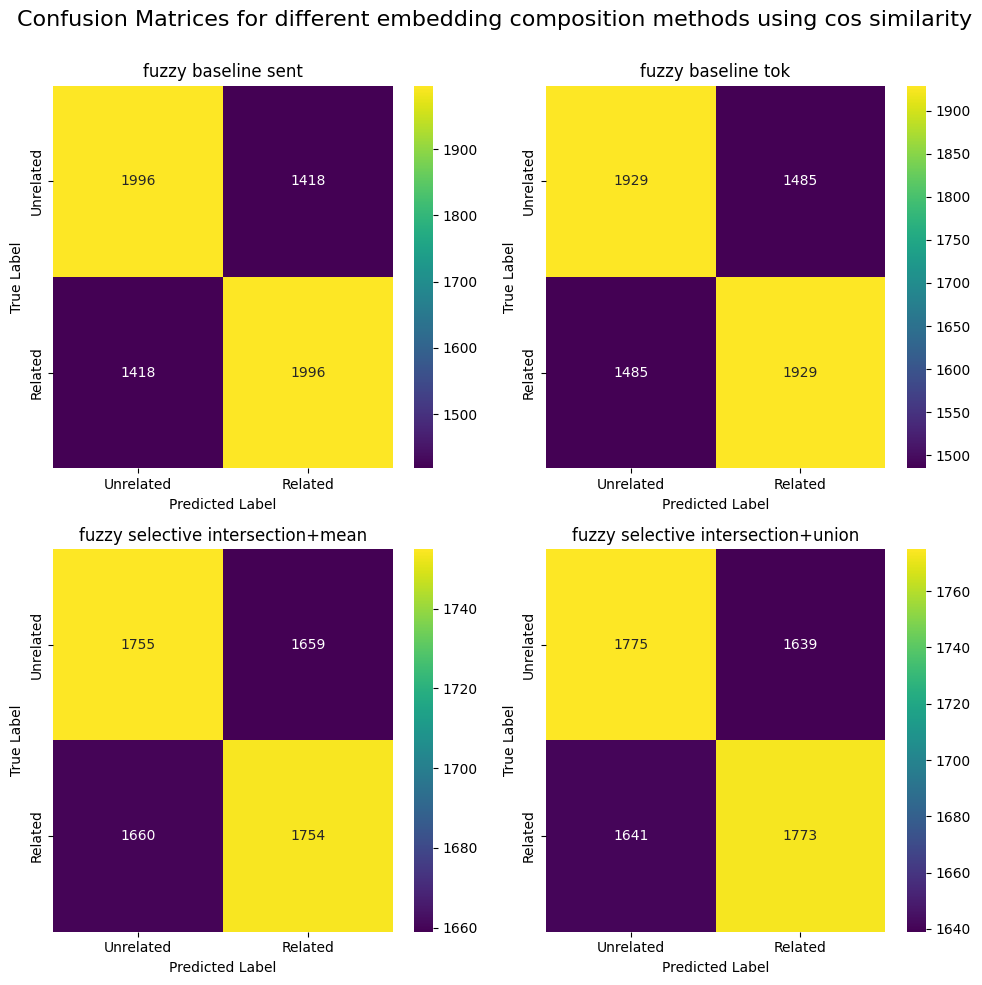

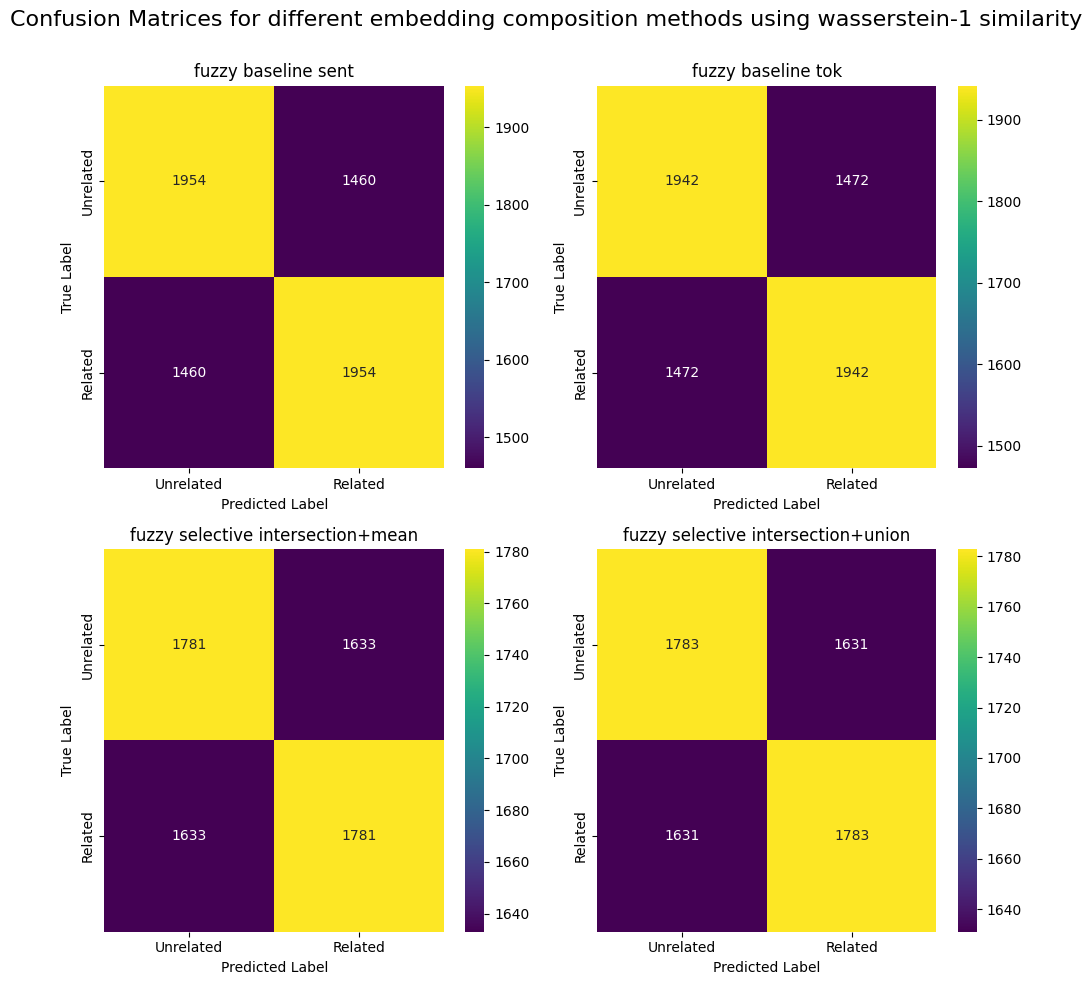

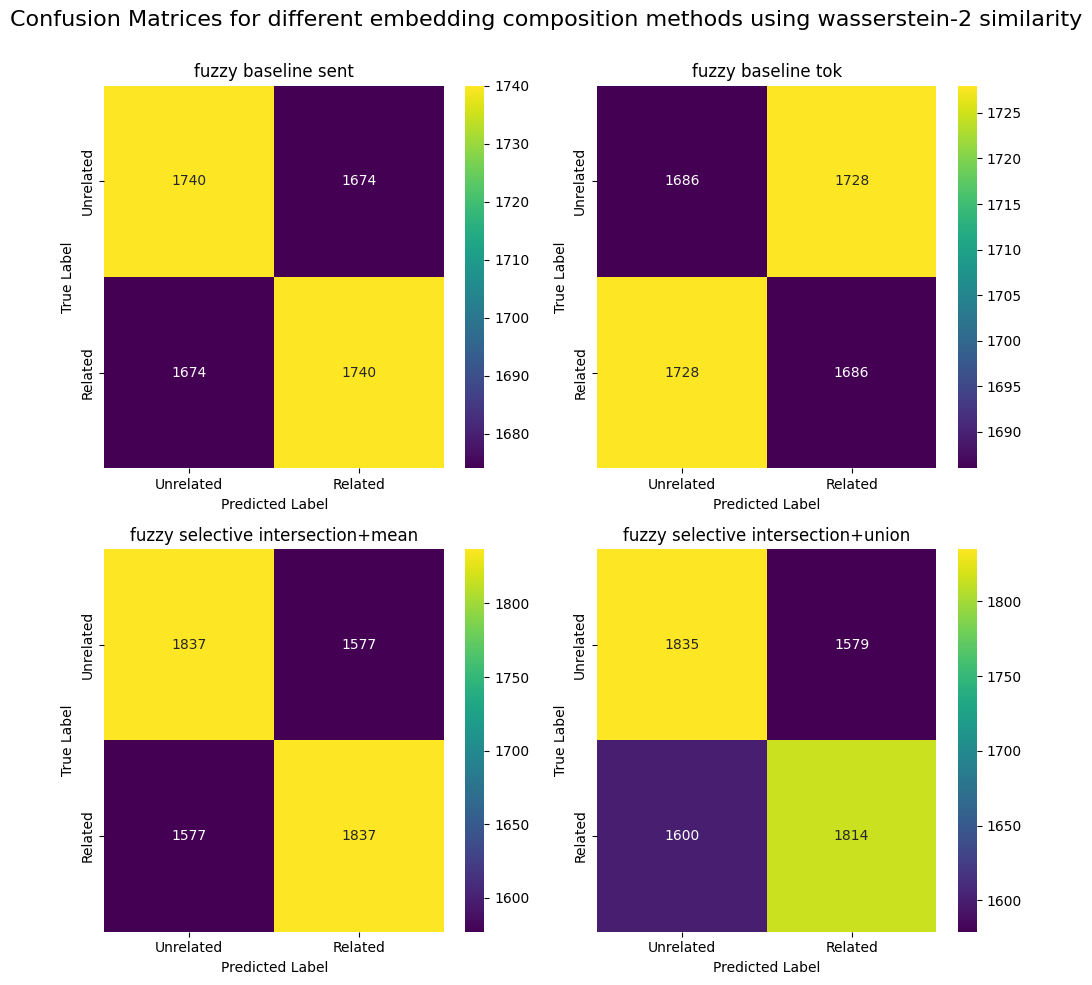

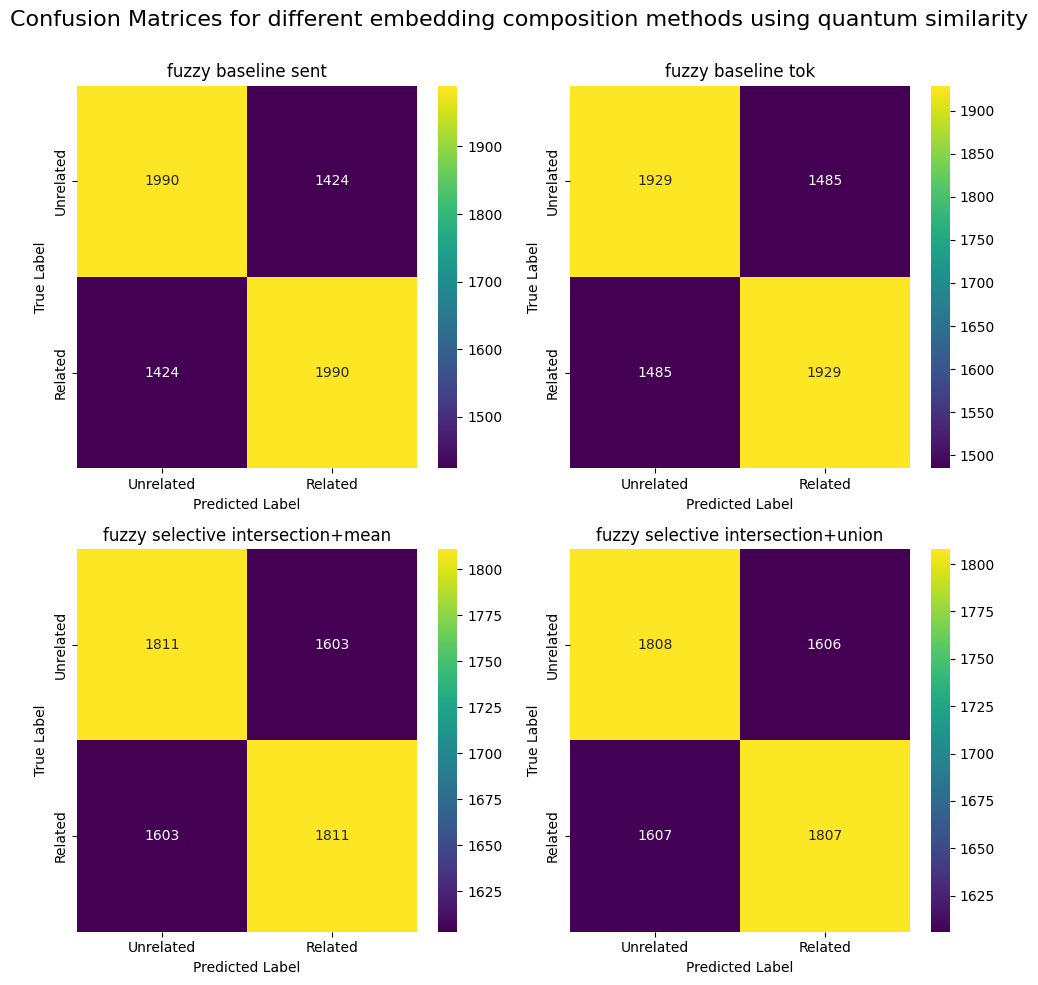

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"fuzzy_{model}_{sim_metric}_sim_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_test
)

# Evaluation Results

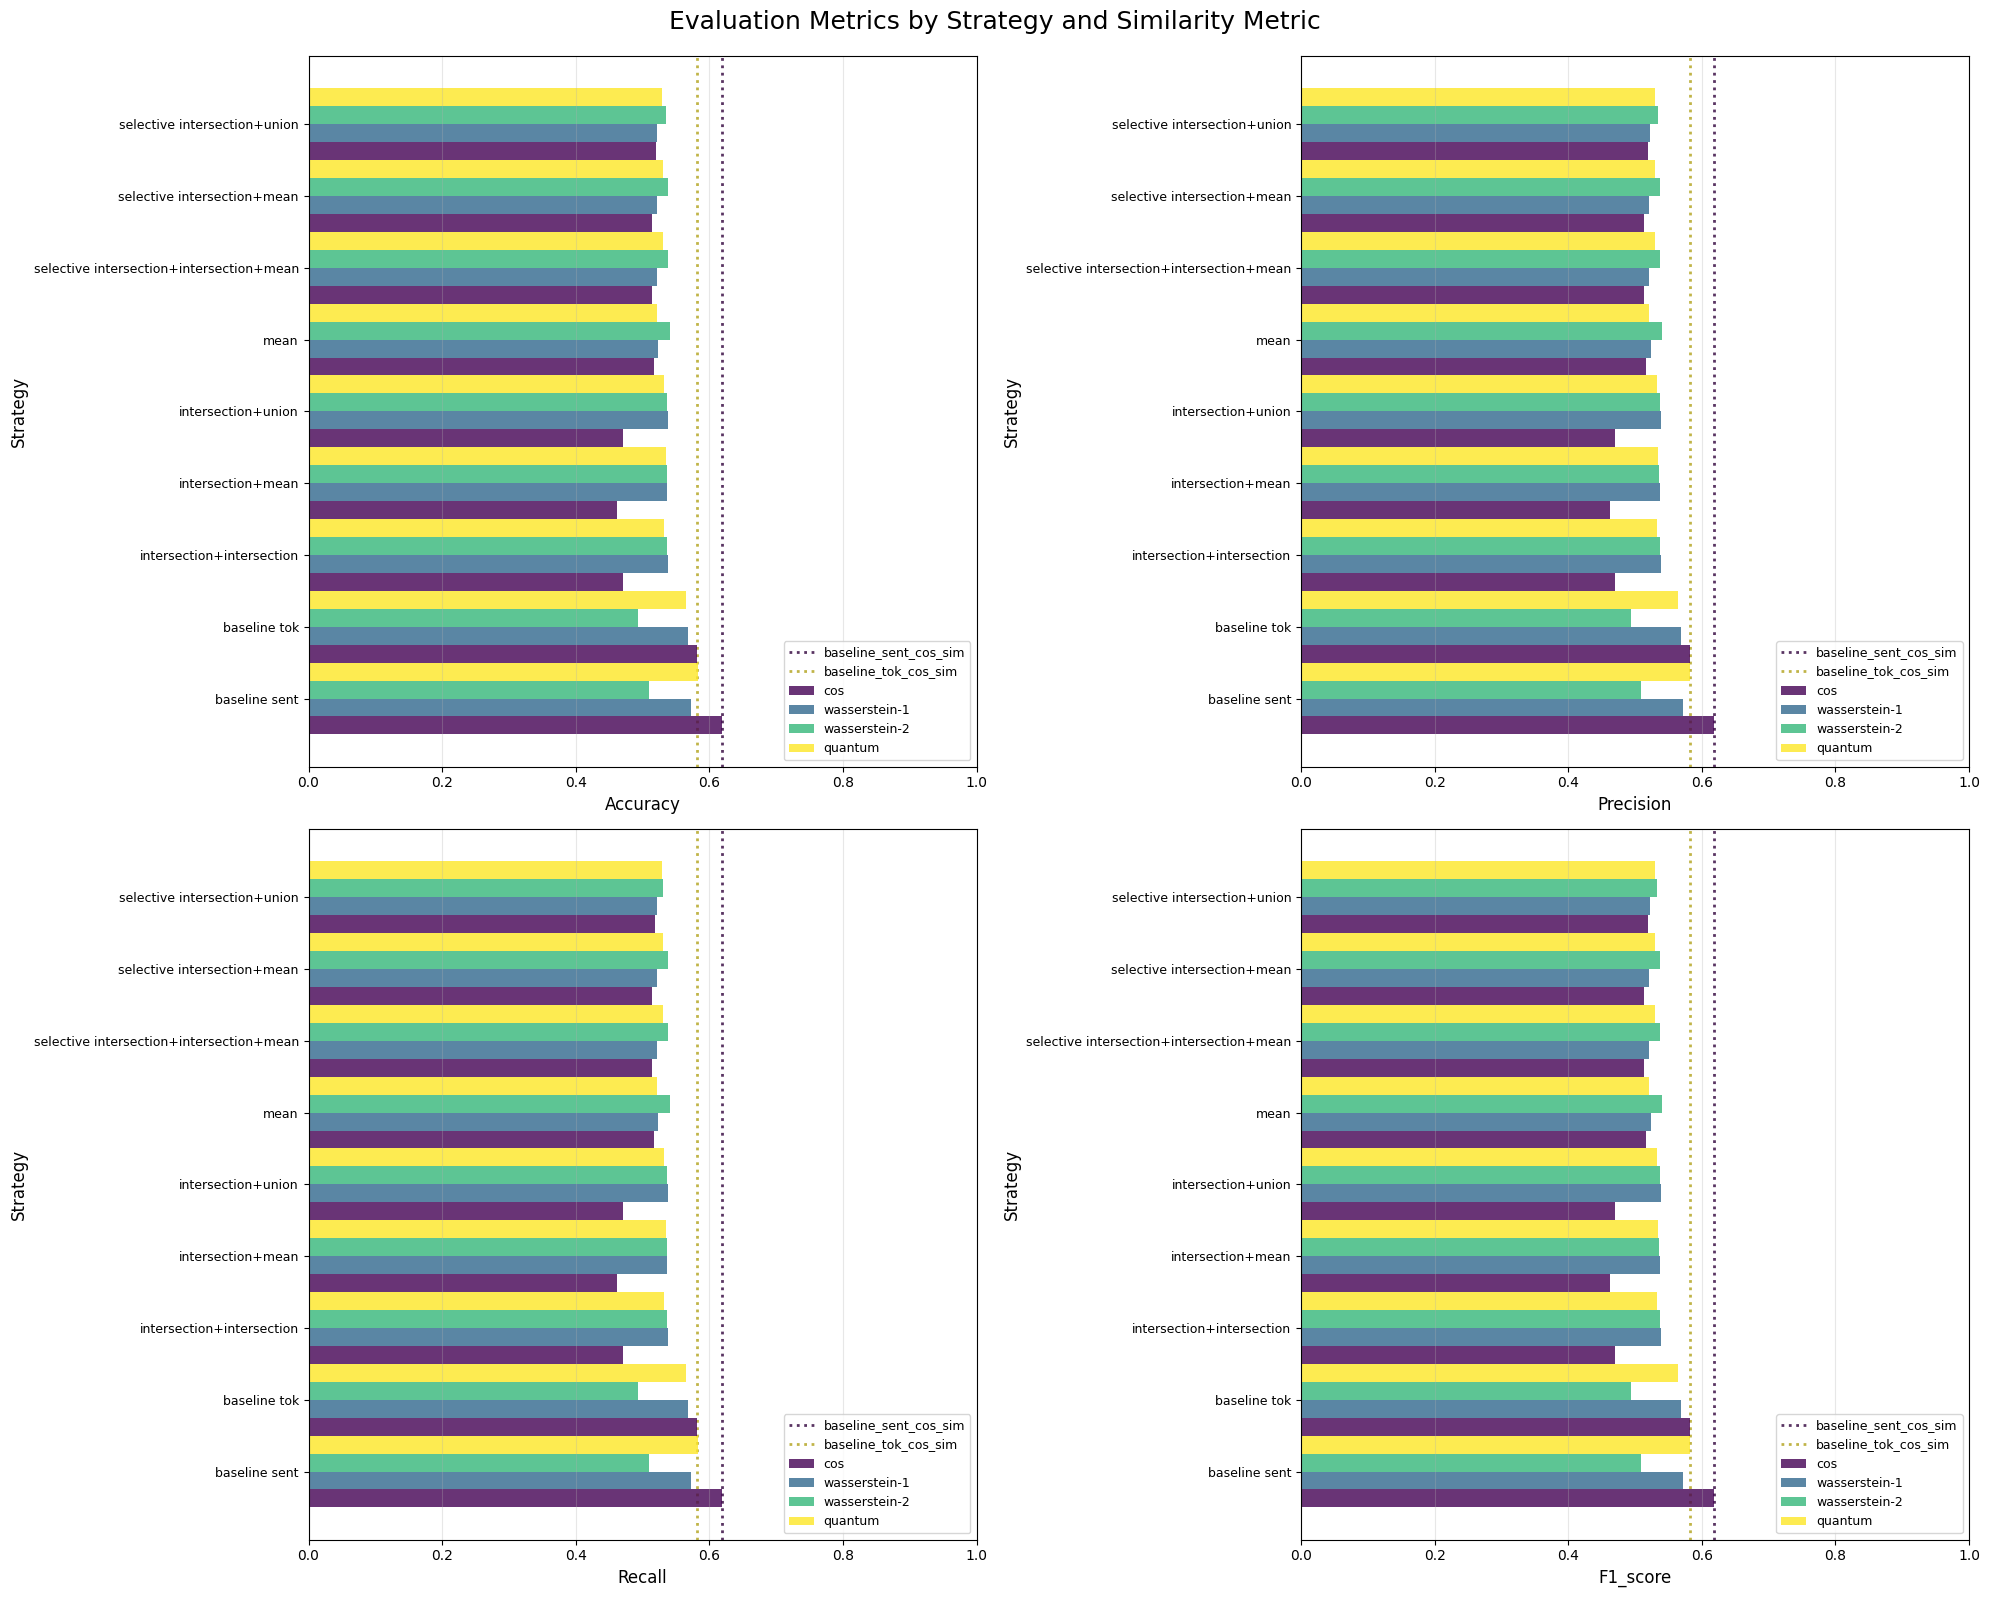

,strategy,similarity_metric,model,accuracy,precision,recall,f1_score
0,baseline_sent,cos,baseline_sent_cos_sim,0.618922,0.618922,0.618922,0.618922
1,baseline_sent,cos,fuzzy_baseline_sent_cos_sim,0.584651,0.584651,0.584651,0.584651
2,baseline_sent,quantum,fuzzy_baseline_sent_quantum_sim,0.582894,0.582894,0.582894,0.582894
3,baseline_tok,cos,baseline_tok_cos_sim,0.582308,0.582308,0.582308,0.582308
4,baseline_sent,wasserstein-1,fuzzy_baseline_sent_wasserstein-1_sim,0.572349,0.572349,0.572349,0.572349
5,baseline_tok,wasserstein-1,fuzzy_baseline_tok_wasserstein-1_sim,0.568834,0.568834,0.568834,0.568834
6,baseline_tok,cos,fuzzy_baseline_tok_cos_sim,0.565026,0.565026,0.565026,0.565026
7,baseline_tok,quantum,fuzzy_baseline_tok_quantum_sim,0.565026,0.565026,0.565026,0.565026
8,mean,wasserstein-2,fuzzy_mean_wasserstein-2_sim,0.540715,0.540715,0.540715,0.540715
9,intersection+intersection,wasserstein-1,fuzzy_intersection+intersection_wasserstein-1_sim,0.538371,0.538371,0.538371,0.538371


In [10]:
metrics_df = eval_harness.score(sim_eval_df, y_test)
metrics_df[:10]

In [11]:
metrics_df.to_csv(f"full_train_eval-wn_enriched={enrich_lemmas_with_wn}-n_components={n_components}-kernel_size={fuzzification_kernel_size}.tsv", sep="\t")